In [8]:
import numpy as np
from matplotlib.pyplot import *
from spectral import imshow, view_cube
import spectral.io.envi as envi
from skimage import io
%matplotlib inline

In [2]:
find_index = lambda x, wvls: np.argmin(np.abs(wvls - x), axis = 0)

In [3]:
sample_image = io.imread(r'D:/Data/Data_HSI/CRAS/Sample_Images/s_antonio_image.jpeg')

In [4]:
fpath = r'D:/Data/Data_HSI/CRAS-Dia2/Transmitancia/'
fname_ref = r'2 -  Santo Antonio/conversion_output/post_processing/santo_antonio_dark_current_compensation_radiometric_correction'
# fnam_white = r'1- Reference White/conversion_output/post_processing/2024-02-28T11_36_19+0000_dark_current_compensation_radiometric_correction'

In [5]:
data_ref = envi.open(fpath + fname_ref + '.hdr', fpath + fname_ref + '.img')
# data_white = envi.open(fpath + fnam_white + '.hdr', fpath + fnam_white + '.img')
data_nparr = np.array(data_ref.load())
# data_white = np.array(data_white.load())[125:580, :, :].mean(axis = 0)

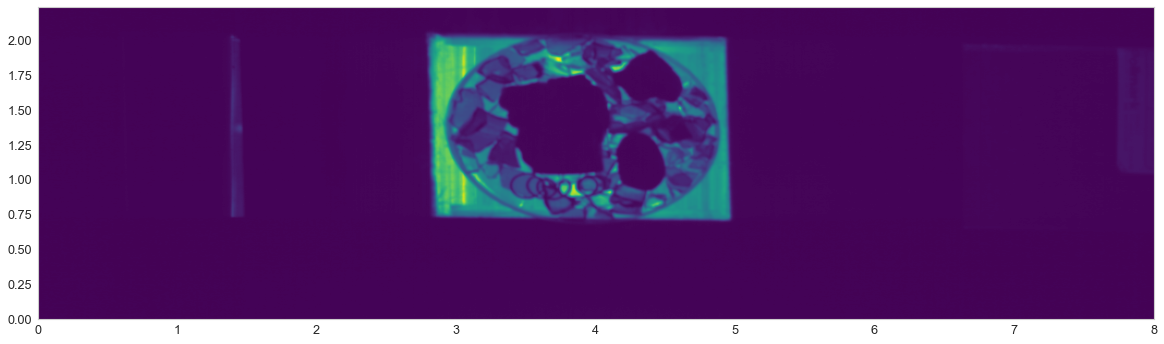

In [15]:
fig, ax = subplots(figsize = (20, 8))
bands = np.array(data_ref.bands.centers)

specim_fps = 1/(1.5e-3)
stage_speed = 10e-3
y_size = data_ref.shape[0]/specim_fps*stage_speed * 1e2 #cm
x_size = 0.08 * 1e2 #cm

ax.imshow(data_nparr[:, :, find_index(650, bands)], extent = (0, x_size, 0, y_size))
ax.grid(False)

In [62]:
corrected_nparr = data_nparr/data_white
bands = np.array(data_ref.bands.centers)

In [29]:
specim_fps = 1/(15e-3)
stage_speed = 10e-3

In [125]:
data_reg = corrected_nparr[220:670, 245:515]
y_size = data_reg.shape[0]/specim_fps*stage_speed * 1e2 #cm
x_size = 0.08 * 1e2 #cm

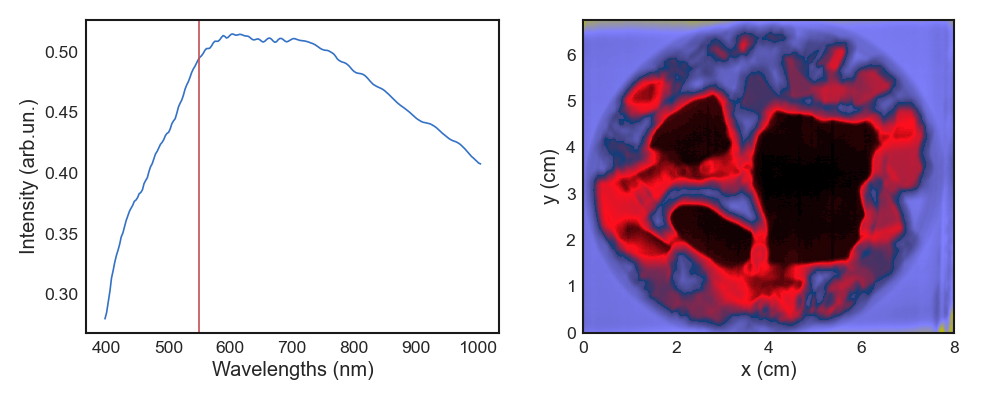

In [154]:
fig, ax = subplots(1, 2, figsize = (10, 4))

wl = 550 #450

axs = ax[0]
axs.plot(bands, data_reg.mean(axis = (0, 1)))
axs.axvline(wl, color = 'r')
axs.set_xlabel('Wavelengths (nm)')
axs.set_ylabel('Intensity (arb.un.)')
axs.grid(False)

axs = ax[1]
axs.imshow(data_reg[:, :, find_index(wl, bands)][::, ::-1], cmap = 'gist_stern', extent = (0, x_size, 0, y_size))
axs.grid(False)
axs.set_xlabel('x (cm)')
axs.set_ylabel('y (cm)')

fig.tight_layout()

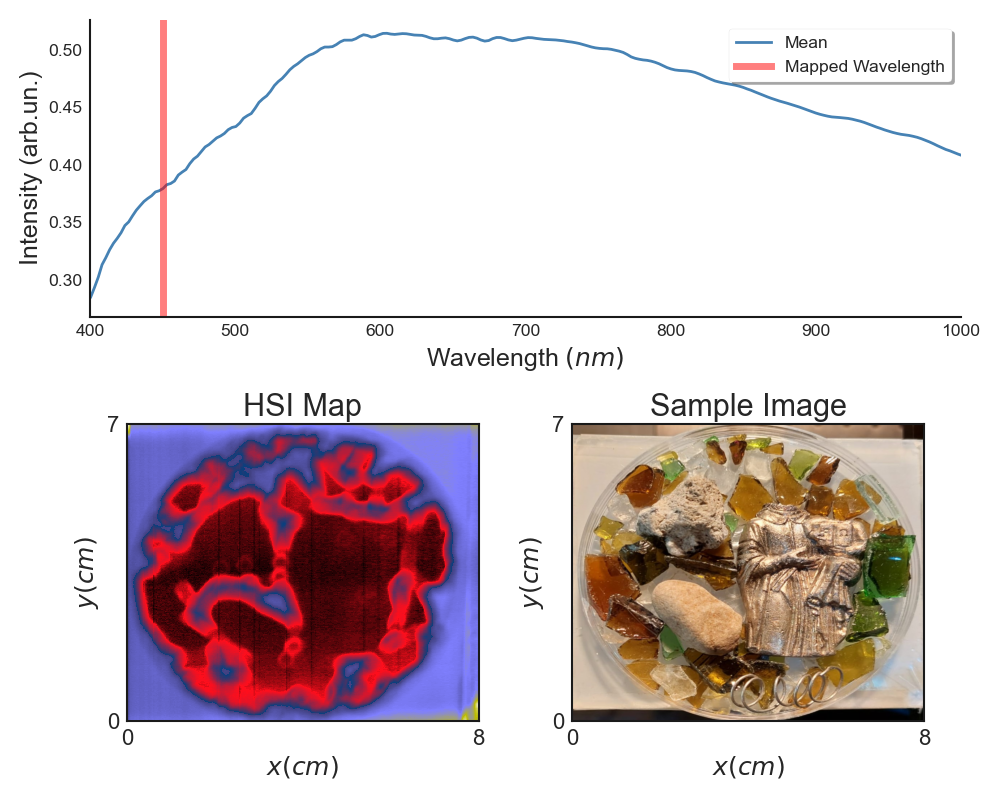

In [139]:
from matplotlib import gridspec

from mpl_toolkits.axes_grid1.inset_locator import mark_inset

matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['axes.edgecolor'] = '0.1'

fig = figure(tight_layout = True, figsize = (10, 8))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])


axs = ax1
# axs.set_title('Mean VIR-NIR HSI Transmittance Signal', fontsize = 22)
axs.plot(bands, data_reg.mean(axis = (0, 1)), lw = 2, ls = '-', color = 'steelblue', label = 'Mean')
axs.set_xlim(400, 1000)
axs.spines[['right', 'top']].set_visible(False)

wn = 450
wv = find_index(wn, bands)
line = axs.axvline(wn, lw = '5', alpha = 0.5, color = 'red', label = 'Mapped Wavelength')
axs.set_xlabel(r'Wavelength $(nm)$', fontsize = 18)
axs.set_ylabel(r'Intensity (arb.un.)', fontsize = 18)
axs.legend(fancybox = True, shadow = True)
axs.grid(False)

axs = ax2
axs.set_title('HSI Map', fontsize = 22)
# axs.imshow(image_var, extent = (0, 90, 0, 80))
# axs.imshow(spectrum[:, :, wn], cmap = my_cmap, extent = (0, 90, 0, 80), interpolation = 'gaussian')

axs.imshow(data_reg[:, :, find_index(wn, bands)][::, ::-1], cmap = 'gist_stern', extent = (0, x_size, 0, y_size))
axs.set_xlabel(r'$x(cm)$', fontsize = 18)
axs.set_ylabel(r'$y(cm)$', fontsize = 18)
axs.set_xticks([0, x_size])
axs.set_xticklabels([0, int(np.round(x_size))], fontsize = 16)
axs.set_yticks([0, y_size])
axs.set_yticklabels([0, int(np.round(y_size))], fontsize = 16)
axs.grid(False)

axs = ax3
axs.set_title('Sample Image', fontsize = 22)
axs.imshow(sample_image, extent = (0, x_size, 0, y_size))
axs.set_xlabel(r'$x(cm)$', fontsize = 18)
axs.set_ylabel(r'$y(cm)$', fontsize = 18)
axs.set_xticks([0, x_size])
axs.set_xticklabels([0, int(np.round(x_size))], fontsize = 16)
axs.set_yticks([0, y_size])
axs.set_yticklabels([0, int(np.round(y_size))], fontsize = 16)
axs.grid(False)

# axin = ax1.inset_axes([0.07, 0.5, 0.2, 0.32])
# axin.set_title(elem[i])
# axin.plot(wavelengths[wv-15:wv+18], np.mean(spectrum[:, :, wv-15:wv+18], axis = (0, 1)), color = 'steelblue', lw = 2)
# axin.fill_between(wavelengths[wv-5:wv+5], 0, np.mean(spectrum[:, :, wv-5:wv+5], axis = (0, 1)), color = 'steelblue', alpha = 0.2)
# axin.set_ylim(np.min(np.mean(spectrum[:, :, wv-15:wv+18], axis = (0, 1)))-10, np.max(np.mean(spectrum[:, :, wv-15:wv+18], axis = (0, 1))) + 10)
# axin.set_xticks([wn])
# axin.set_yticks([np.round(np.max(np.mean(spectrum[:, :, wv-15:wv+18], axis = (0, 1))), 0)])
# axin.set_xticklabels([np.round(wn, 2)], fontsize = 12)
# axin.grid(False)
# setp(list(axin.spines.values()), linewidth = 1.2, edgecolor = 'black')
# mark_inset(ax1, axin, loc1 = 3, loc2 = 4, fc = "none", ec = "0")

fig.tight_layout()
savefig('green.jpg', dpi = 300, bbox_inches = 'tight')

In [129]:
np.round(y_size)

7.0